In [57]:
import numpy as np

def ZeDA(sig, t1, tn, real=[], level=0.0,  plotting=False, method='std', score=3.0):
    """This function takes a uniformly sampled time series and finds the number of crossings

    Args:
    sig (numpy array):   Time series (1d) in format of npy.
    t1 (float):          Initial time of recording signal.
    tn (float):          Final time of recording signal.

    Other Parameters:
    level (Optional[float]):  Level at which crossings are to be found; default: 0.0 for zero-crossings
    plotting (Optional[bool]): Plots the function with returned brackets; defaut is False.
    method (Optional[str]): Method to use for setting persistence threshold; 'std' for standard deviation, 'iso' for isolation forest, 'dt' for smallest time interval in case of a clean signal; default is std (3*standard deviation)
    score (Optional[float]): z-score to use if method == 'std'; default is 3.0

    Returns:
    [brackets, crossings, flags]: brackets gives intervals in the form of tuples where a crossing is expected; crossings gives the estimated crossings in each interval obtained by averaging both ends; flags marks, for each interval, whether both ends belong to the same sgn(function) category (0, unflagged; 1, flagged)

    """

    ##############################################################
    # Sorts time series in P and Q point clouds
    def sortPQ(sig, t):

        p = np.sort(t[np.sign(sig) == 1]).tolist()
        q = np.sort(t[np.sign(sig) == -1]).tolist()

        # Adding endpoints if not already there
        if t[0] not in p:
            p.append(t[0])
        if t[0] not in q:
            q.append(t[0])
        if t[-1] not in p:
            p.append(t[-1])
        if t[-1] not in q:
            q.append(t[-1])

        p.sort()
        q.sort()

        return p, q

    ################################################################
    # Find points in persistence diagram above the threshold mu
    def sortPQ_mu(p, q, zscore=score):

        import statistics

        p_mu = []
        q_mu = []

        if method == 'std':
            p_per = np.diff(p)
            q_per = np.diff(q)
            lst = list(p_per) + list(q_per)
            dev = statistics.stdev(lst)
            mu = zscore * dev
        elif method == 'dt':
            mu = 1.9*(tn - t1)/np.size(sig)

        n = 0
        while n < len(p) - 1:
            if p[n + 1] - p[n] > mu:
                p_mu.append(p[n])
                p_mu.append(p[n + 1])
            n = n + 1

        n = 0
        while n < len(q) - 1:
            if q[n + 1] - q[n] > mu:
                q_mu.append(q[n])
                q_mu.append(q[n + 1])
            n = n + 1

        p_mu = list(set(p_mu))
        p_mu.sort()
        q_mu = list(set(q_mu))
        q_mu.sort()

        return p_mu, q_mu

    ################################################################
    # Find outliers in persistence diagram using Isolation Forest
    def sortPQ_outlier(p, q):

        p_mu = []
        q_mu = []

        p_per = np.diff(p)
        q_per = np.diff(q)

        y = list(p_per) + list(q_per)
        X = list(range(0, len(y)))

        import pandas as pd
        from sklearn.ensemble import IsolationForest

        data_values = np.array(list(zip(X, y)))

        data = pd.DataFrame(data_values, columns=['x', 'y'])

        def fit_model(model, data, column='y'):
            df = data.copy()
            data_to_predict = data[column].to_numpy().reshape(-1, 1)
            predictions = model.fit_predict(data_to_predict)
            df['Predictions'] = predictions
            return df

        iso_forest = IsolationForest(n_estimators=125)
        iso_df = fit_model(iso_forest, data)
        iso_df['Predictions'] = iso_df['Predictions'].map(lambda x: 1 if x == -1 else 0)

        predictions = iso_df['Predictions'].to_numpy()

        cat_p = predictions[0:len(p_per) - 1]
        cat_q = predictions[len(p_per):len(p_per) + len(q_per) - 1]

        for i in range(0, len(predictions)):
            if i < len(p_per):
                if predictions[i] == 1:
                    p_mu.append(p[i])
                    p_mu.append(p[i+1])

            if i >= len(p_per):
                if predictions[i] == 1:
                    q_mu.append(q[i - len(p_per)])
                    q_mu.append(q[i - len(p_per) + 1])

        return p_mu, q_mu

    ####################################################################
    # Interleave P_mu and Q_mu
    def interleave(p_mu, q_mu):

        import operator

        I_index = [*range(0, len(p_mu))] + [*range(len(p_mu), len(p_mu) + len(q_mu))]
        I = p_mu + q_mu

        I_dict = dict(zip(I_index, I))

        if len(p_mu) == 0:
            if t[0] != I_dict[0]:
                I_dict[-1] = t[0]
            else:
                del I_dict[0]
            if t[len(t) - 1] != I_dict[len(q_mu) - 1]:
                I_dict[len(q_mu)] = t[len(t) - 1]
            else:
                del I_dict[len(q_mu) - 1]

        if len(q_mu) == 0:
            if t[0] != I_dict[0]:
                I_dict[-1] = t[0]
            else:
                del I_dict[0]
            if t[len(t) - 1] != I_dict[len(p_mu) - 1]:
                I_dict[len(p_mu)] = t[len(t) - 1]
            else:
                del I_dict[len(p_mu) - 1]

        if len(p_mu) != 0 and len(q_mu) != 0:
            if t[0] != I_dict[0] and t[0] != I_dict[len(p_mu)]:
                I_dict[-1] = t[0]
            else:
                if t[0] == I_dict[0] and t[0] == I_dict[len(p_mu)]:
                    del I_dict[0]
                    del I_dict[len(p_mu)]
                elif t[0] == I_dict[0]:
                    del I_dict[0]
                else:
                    del I_dict[len(p_mu)]

            if t[len(t) - 1] != I_dict[len(p_mu) - 1] and t[len(t) - 1] != I_dict[len(p_mu) + len(q_mu) - 1]:
                I_dict[len(p_mu) + len(q_mu)] = t[len(t) - 1]
            else:
                if t[len(t) - 1] == I_dict[len(p_mu) - 1] and t[len(t) - 1] == I_dict[len(p_mu) + len(q_mu) - 1]:
                    del I_dict[len(p_mu) - 1]
                    del I_dict[len(p_mu) + len(q_mu) - 1]
                elif t[len(t) - 1] == I_dict[len(p_mu) - 1]:
                    del I_dict[len(p_mu) - 1]
                else:
                    del I_dict[len(p_mu) + len(q_mu) - 1]

        sorted_tuples = sorted(I_dict.items(), key=operator.itemgetter(1))
        I_dict = {k: v for k, v in sorted_tuples}

        brackets = list(zip(*[iter(I_dict.values())] * 2))

        n = 0
        ZC = []
        flag = []
        for n in range(0, len(brackets)):

            k1 = [i for i in I_dict if I_dict[i] == brackets[n][0]]
            k2 = [i for i in I_dict if I_dict[i] == brackets[n][1]]
            t1 = k1[0] in range(0, len(p_mu))
            t2 = k2[0] in range(len(p_mu), len(p_mu) + len(q_mu))

            root = 0.5 * (brackets[n][0] + brackets[n][1])
            ZC.append(root)

            if (t1 ^ t2):
                flag.append(1)
            else:
                flag.append(0)

        return brackets, ZC, flag

    #########################################################################
    # ZeDA Function

    sig = sig - level
    t = np.linspace(t1, tn, np.size(sig), endpoint=True)

    p, q = sortPQ(sig, t)

    if len(p) == len(t) or len(q) == len(t):
        print("The signal does not appear to have any crossings.")
        return [], [], []

    if method == 'std':
        p_mu, q_mu = sortPQ_mu(p, q)
        c = 0
        while len(p_mu) == 0 and len(q_mu) == 0:
            print("The z-score is high, lowering it by 0.25.")
            score = score - 0.25
            p_mu, q_mu = sortPQ_mu(p, q, score)
            c = c+1
        if c > 0:
            print(f"z-score used to find outliers is {score}.")

    elif method == 'dt':
        p_mu, q_mu = sortPQ_mu(p, q)

    elif method == 'iso':
        p_mu, q_mu = sortPQ_outlier(p, q)
        if len(p_mu) == 0 and len(q_mu) == 0:
            print("The method 'iso' could not detect any points. Please use another method.")

    else:
        print('Keyword for method unrecognized. Use "std" for standard deviation, "iso" for Isolation Forest, or "dt" for signal with no noise.')
        return [], [], []

    brackets, ZC, Flag = interleave(p_mu, q_mu)

    #######################################################################
    # Plot Everything, if plotting == True
    if plotting == True:

        import matplotlib.pyplot as plt
        from matplotlib import rc
        rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
        rc('text', usetex=True)
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        plt.figure(figsize=(6, 5), dpi=200)

        plt.plot(t, sig, linewidth=2.5, alpha=1)
        plt.axhline(y=0, linewidth=2.5, linestyle=':', color='black', label='_nolegend_')
        plt.xlim([t1, tn])
        plt.xticks([-2, -1, 0, 1, 2], fontsize=25)
        plt.yticks(fontsize=25)
        plt.xlabel("Time", fontsize=25)
        plt.ylabel("Amplitude", fontsize=25)

        ymin, ymax = plt.gca().get_ylim()
        plt.vlines(brackets, ymin=ymin, ymax=ymax, linewidth=2.0, color='green', linestyle='--')

        n = np.zeros(len(ZC))
        plt.scatter(ZC, n, s=300, color='black', marker='o', zorder=1)
        if len(real)>0:
            n = np.zeros(len(real))
            plt.scatter(real, n, s=300, color='red', marker='*', zorder=2)

        plt.legend(['Signal', 'Brackets', 'Roots', 'True Roots'], fontsize=25)

        plt.tight_layout()
        plt.show()

    ##################################################################
    # Return Brackets, Crossings and Flags
    # print("Brackets are: ", brackets)
    # print("Estimated crossings are: ", ZC)
    # print("Corresponding flags are: ", Flag)

    return brackets, ZC, Flag

seed = 0

### Figure 6

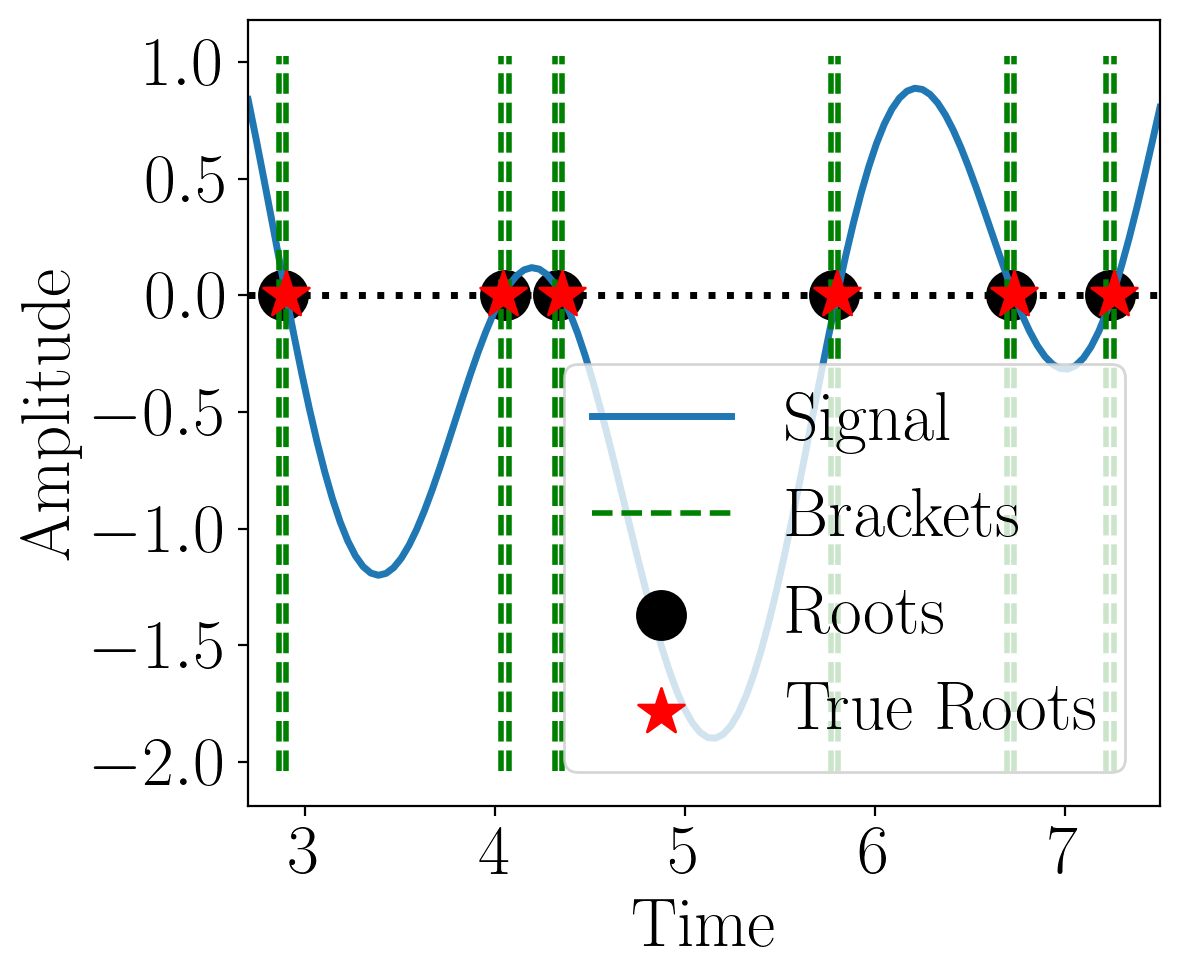

In [49]:
# x2

t1 = 2.7
tn = 7.5
fs = 25
sample_num = np.multiply((tn - t1), fs)

t = np.linspace(t1, tn, round(sample_num), endpoint=True)
sig1 = np.sin(t) + np.sin(10*t/3)

brackets, ZC, flag = ZeDA(sig1, t1, tn, real=np.array([2.9, 4.039, 4.3499, 5.79986, 6.73198, 7.2598]), level=0.0,  plotting=True, method='dt')

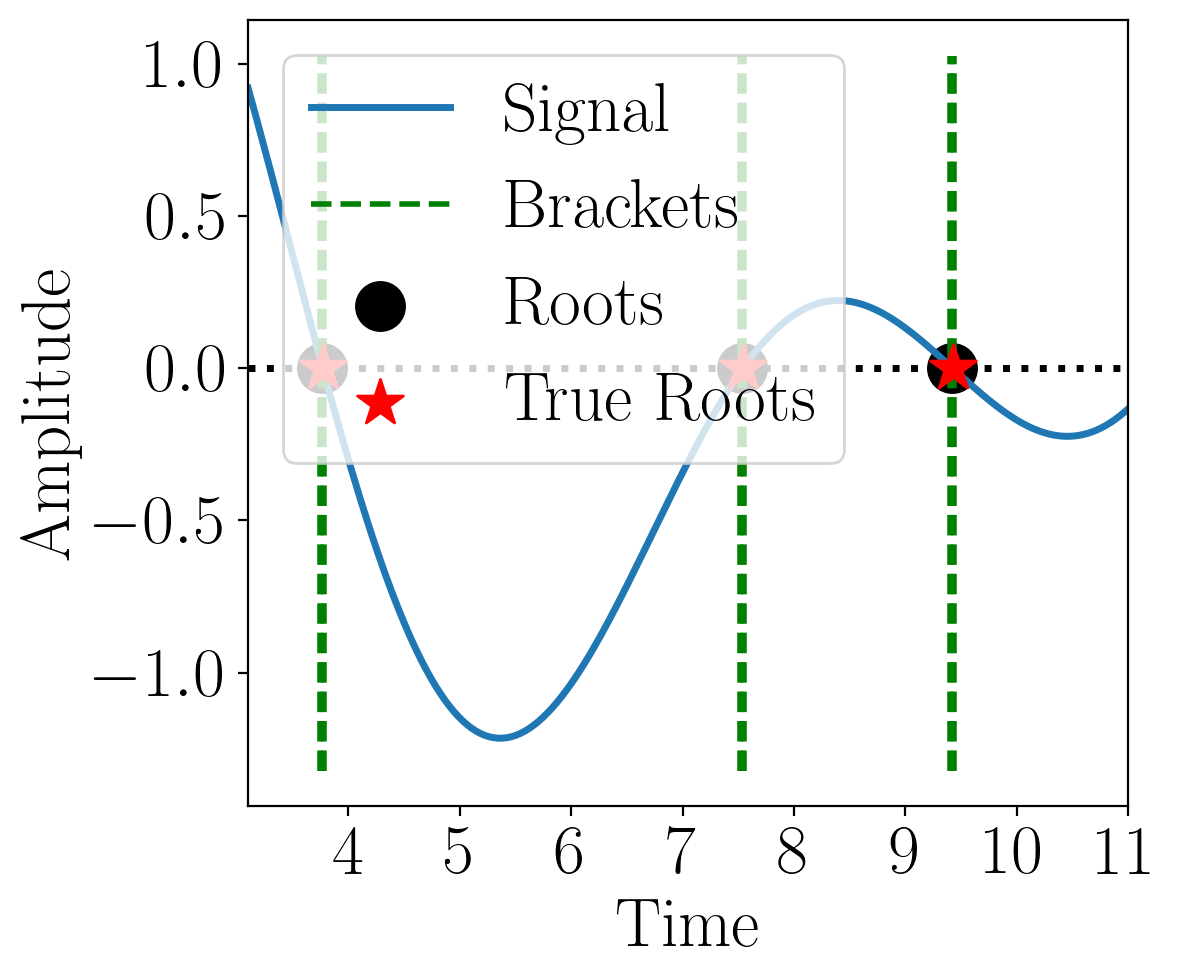

In [50]:
# x5

t1 = 3.1
tn = 11
fs = 25
sample_num = np.multiply((tn - t1), fs)

t = np.linspace(t1, tn, round(sample_num), endpoint=True)
sig1 = np.sin(t) + np.sin(2*t/3)

brackets, ZC, flag = ZeDA(sig1, t1, tn, real=np.array([3.77, 7.54, 9.425]), level=0.0,  plotting=True, method='dt')

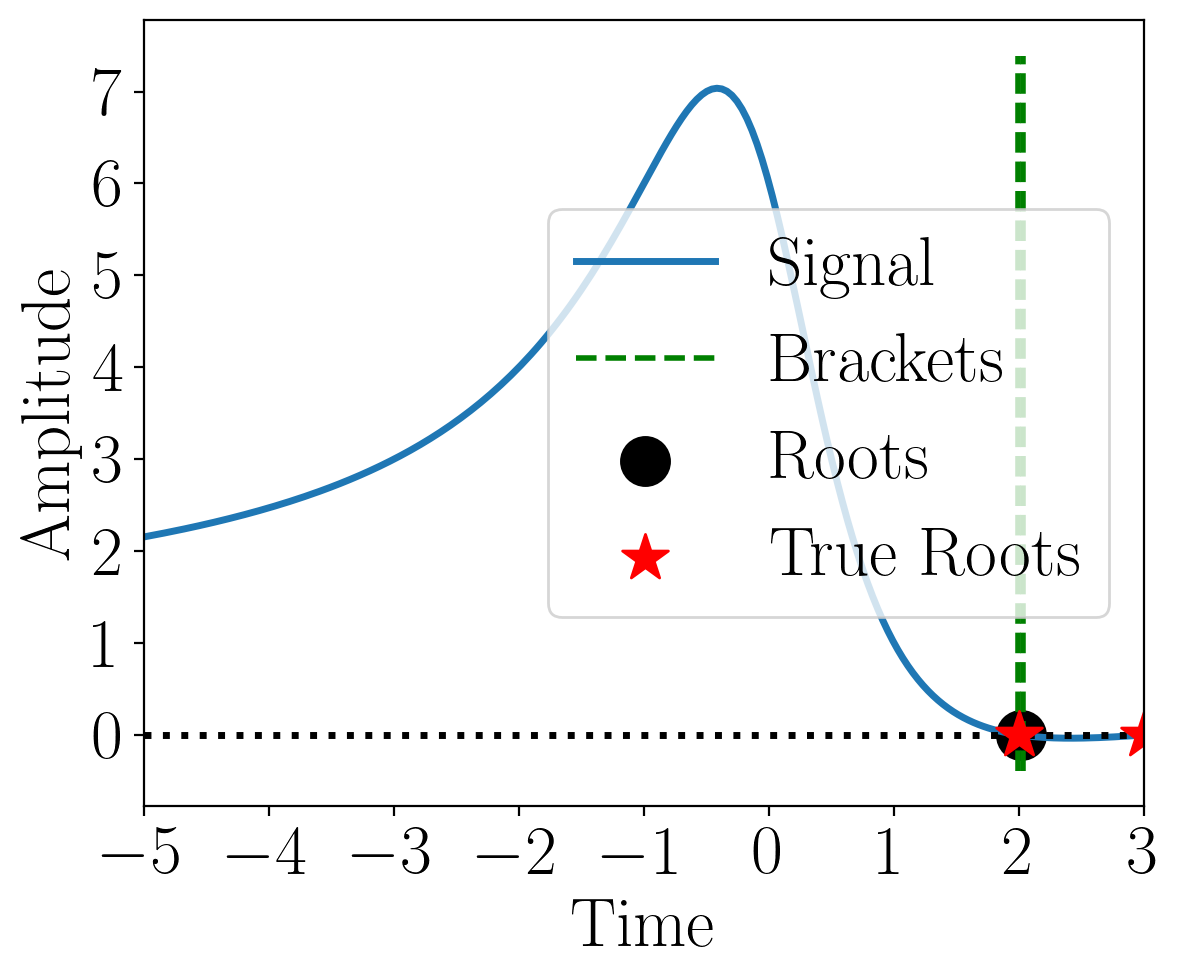

In [51]:
# x11

t1 = -5
tn = 3
fs = 25
sample_num = np.multiply((tn - t1), fs)

t = np.linspace(t1, tn, round(sample_num), endpoint=True)
sig1 = np.divide(np.power(t, 2) - 5*t + 6, np.power(t, 2) + 1)

brackets, ZC, flag = ZeDA(sig1, t1, tn, real=np.array([2, 3]), level=0.0,  plotting=True, method='dt')

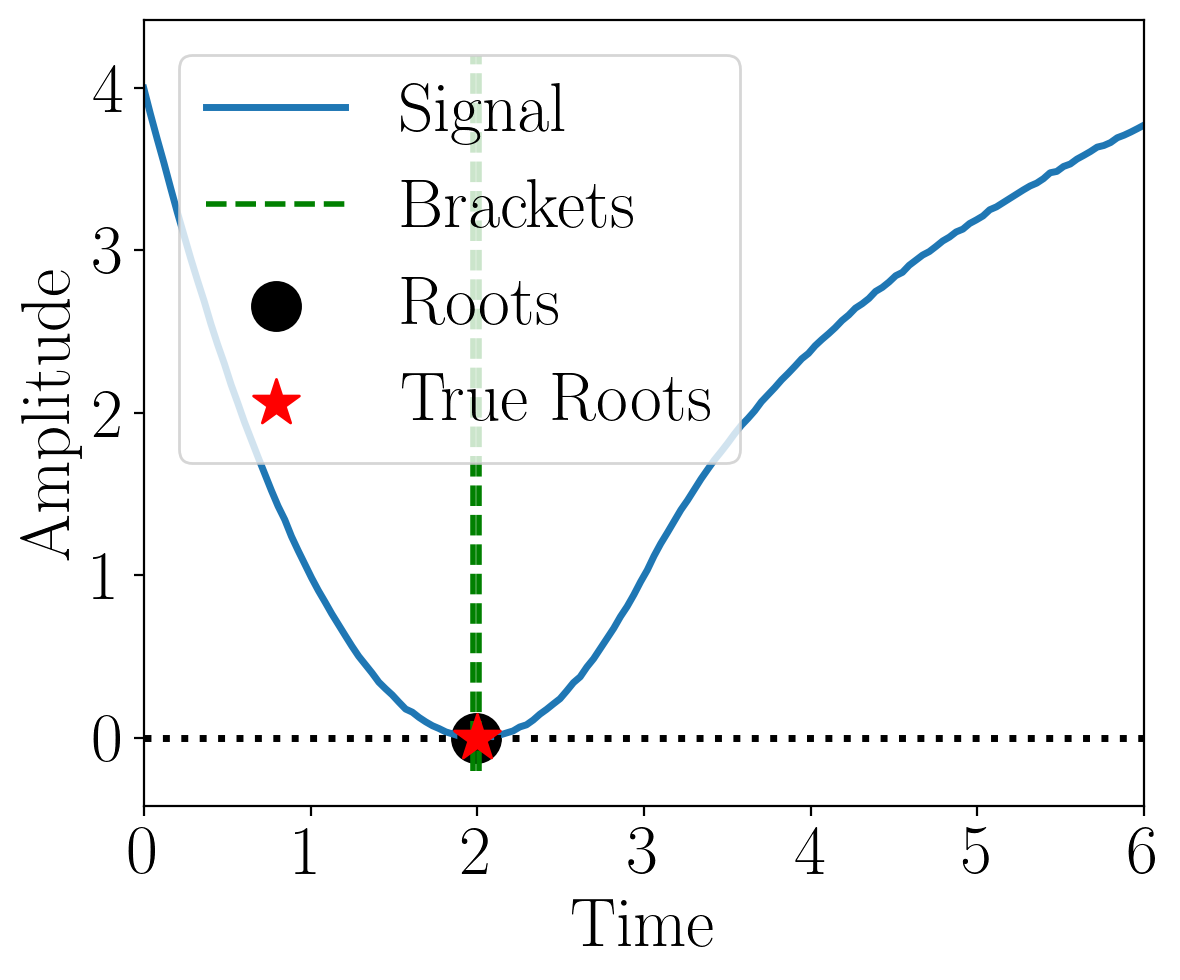

In [53]:
# x12

t1 = 0
tn = 6
fs = 25
sample_num = np.multiply((tn - t1), fs)

t = np.linspace(t1, tn, round(sample_num), endpoint=True)
sig1 = []
for i in range(0, len(t)):
    if t[i] <= 3:
        sig1.append(np.power(t[i] - 2, 2))
    else:
        sig1.append(2 * np.log(t[i] - 2) + 1)
sig1 = np.array(sig1)

### Clean signal has root on x-axis. Adding a very little noise to make it
power_signal = np.average(sig1 * sig1)
SNR_100 = np.power(10, 55 / 10)
mu_g, sigma = 0, np.sqrt(power_signal / SNR_100)
noise = np.random.normal(mu_g, sigma, round(sample_num))
sig1 = sig1 + noise

brackets, ZC, flag = ZeDA(sig1, t1, tn, real=np.array([2]), level=0.0,  plotting=True, method='std')

### Figure 7

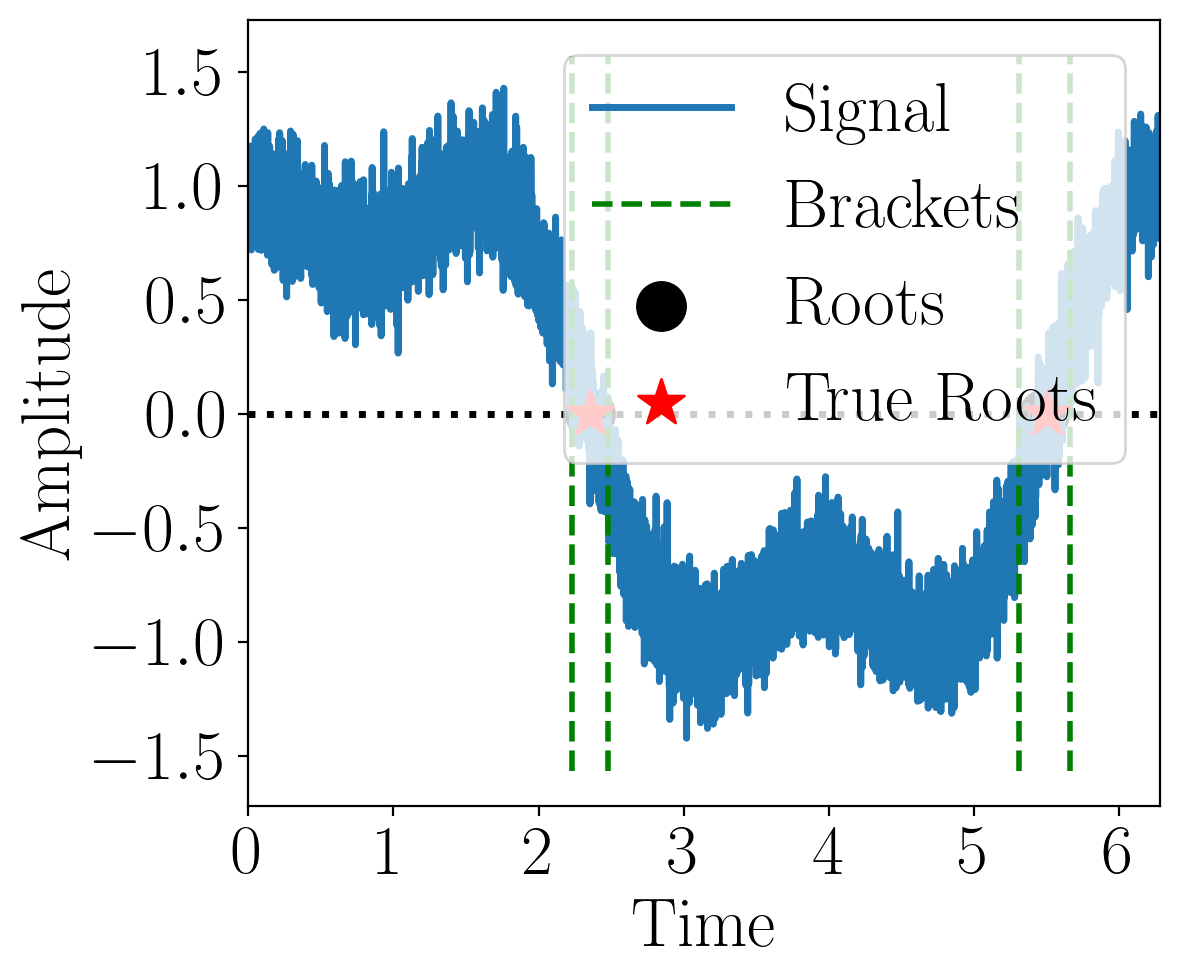

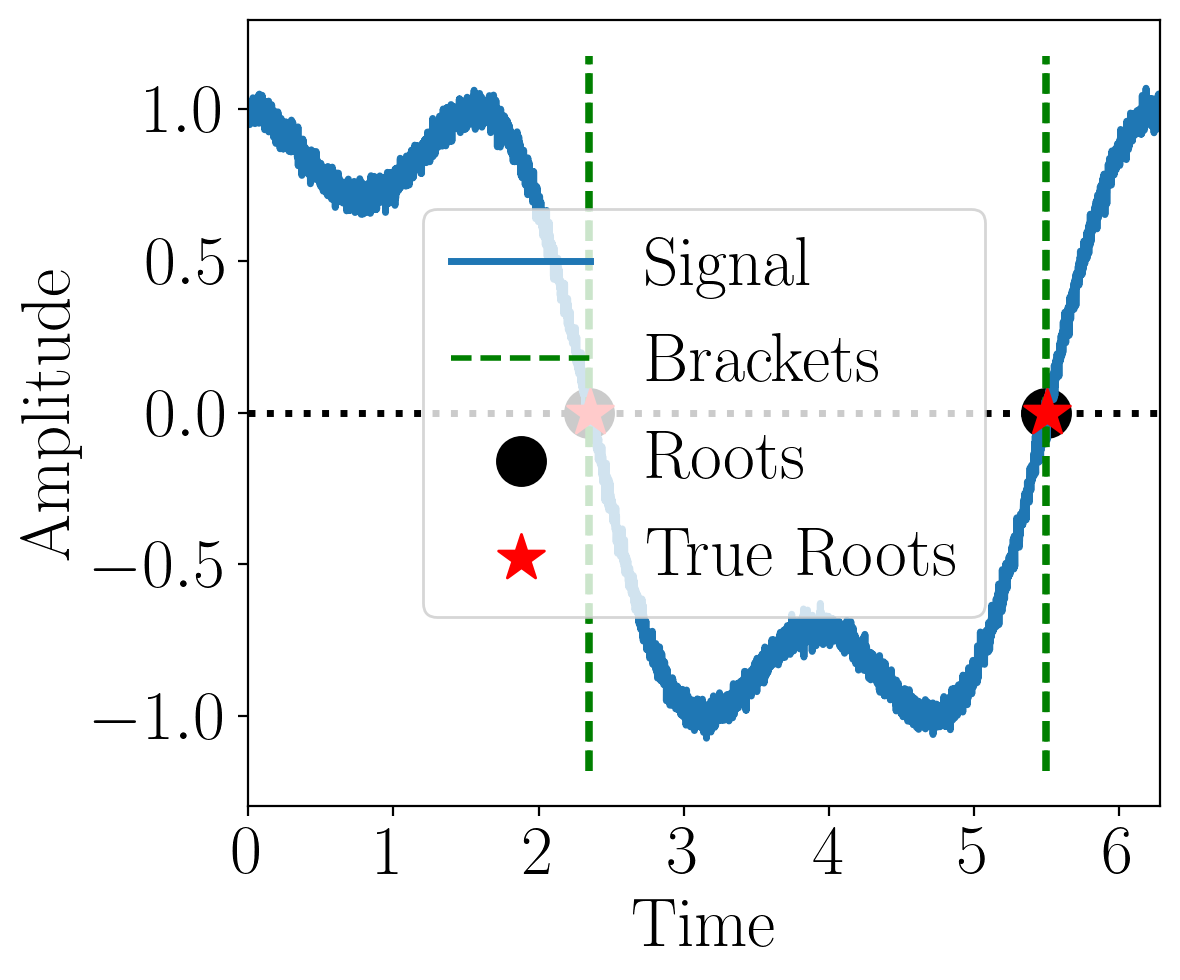

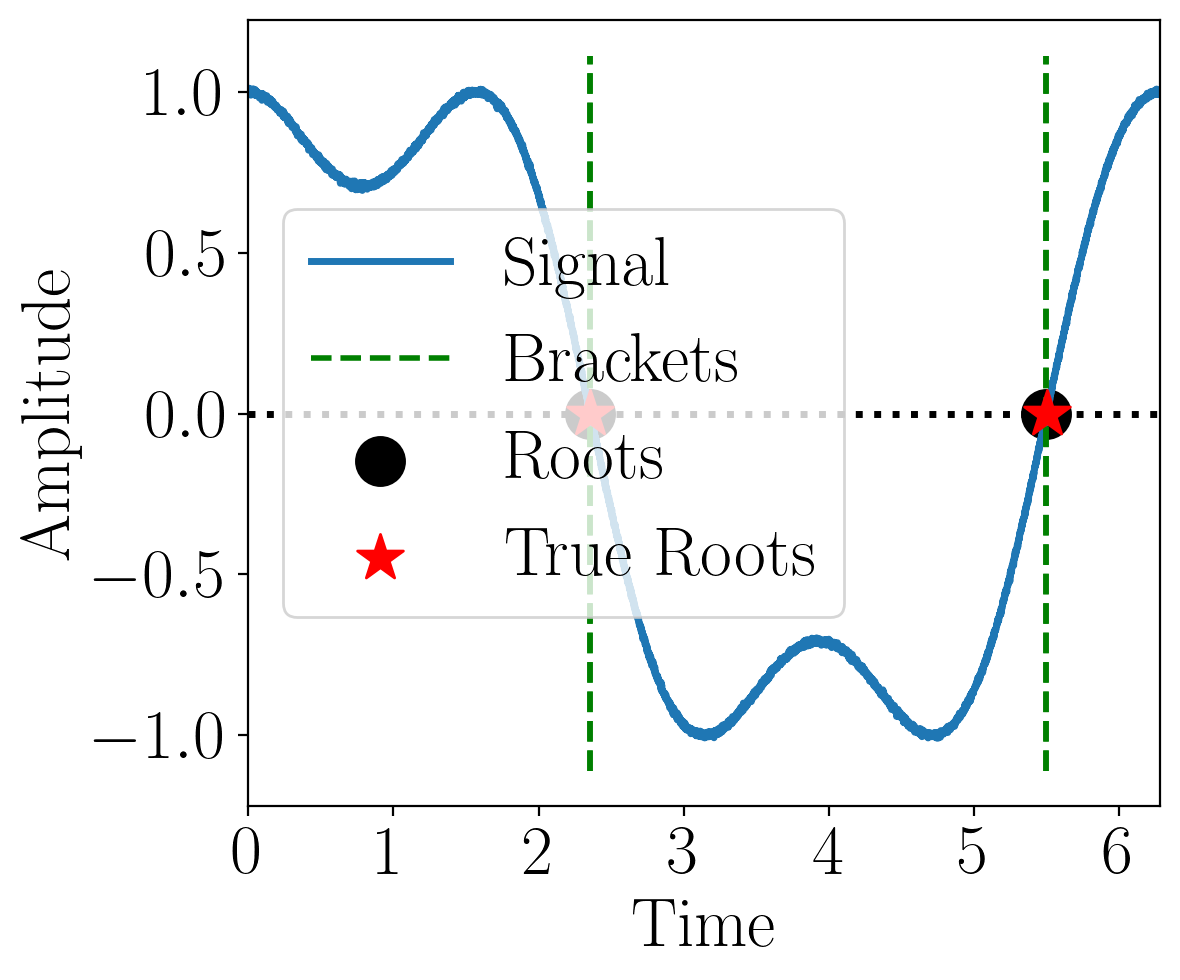

In [54]:
# x8

t1 = 0
tn = 6.28
fs = 1000
sample_num = np.multiply((tn - t1), fs)

for SNR_db in [15, 30, 45]:

    t = np.linspace(t1, tn, round(sample_num), endpoint=True)
    sig1 = np.power(np.sin(t), 3) + np.power(np.cos(t), 3)

    power_signal = np.average(sig1 * sig1)
    SNR_100 = np.power(10, SNR_db / 10)
    mu_g, sigma = 0, np.sqrt(power_signal / SNR_100)
    noise = np.random.normal(mu_g, sigma, round(sample_num))
    sig1 = sig1 + noise

    brackets, ZC, flag = ZeDA(sig1, t1, tn, real=np.array([2.356, 5.5]), level=0.0,  plotting=True, method='std')

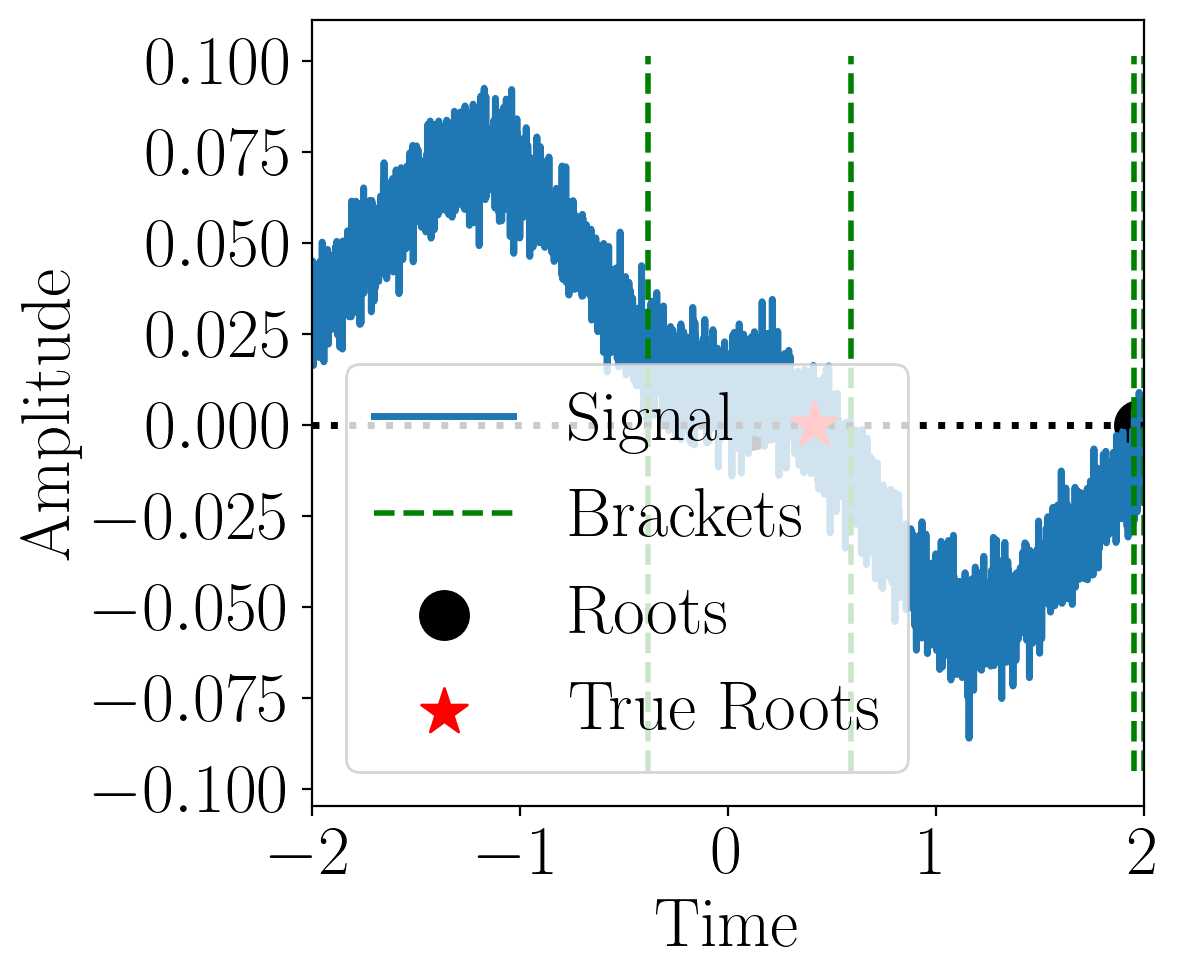

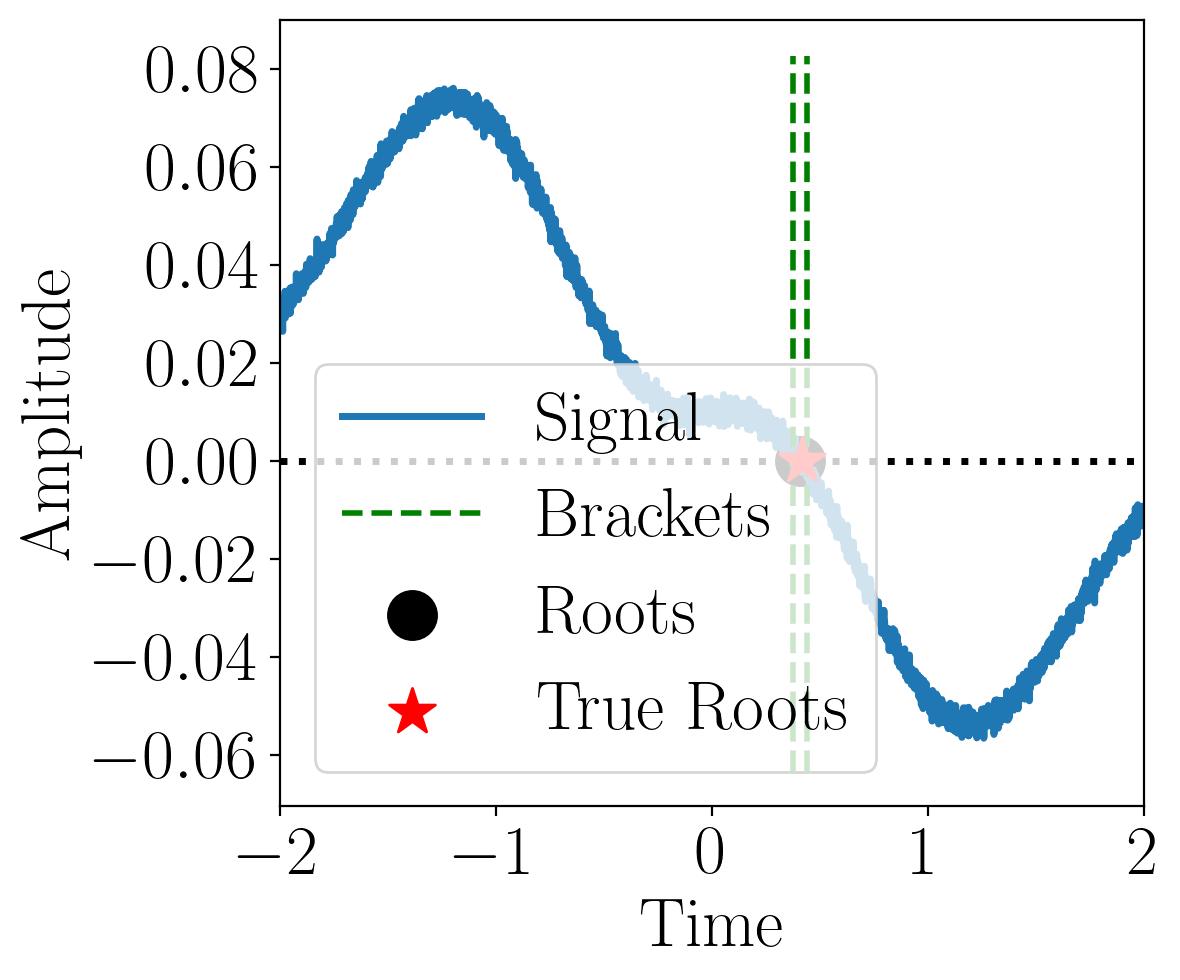

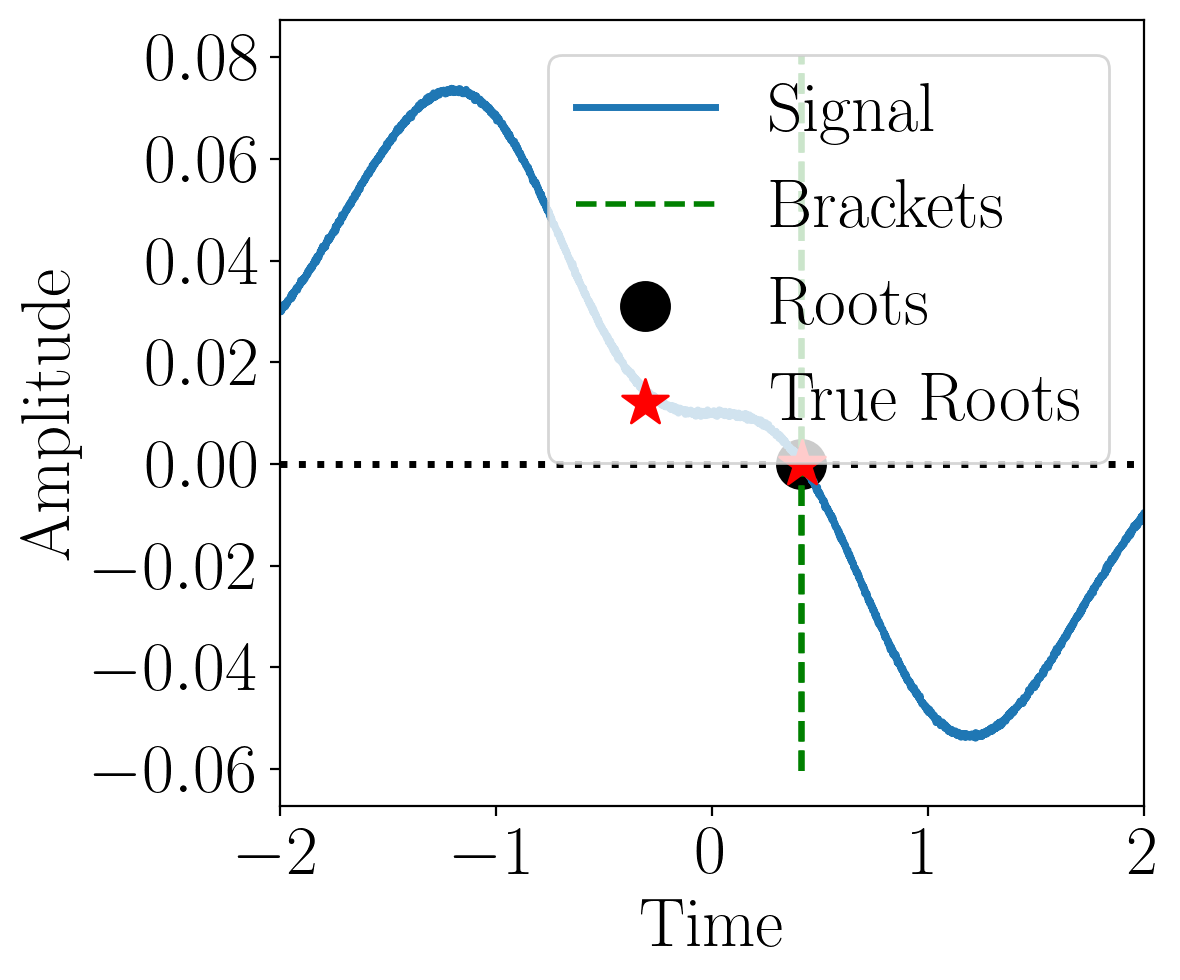

In [59]:
# x14

t1 = -2
tn = 2
fs = 1000
sample_num = np.multiply((tn - t1), fs)

for SNR_db in [15, 30, 45]:

    t = np.linspace(t1, tn, round(sample_num), endpoint=True)
    sig1 = -1*(t - np.sin(t))*np.power(np.e, -1*np.power(t, 2)) + 0.01

    power_signal = np.average(sig1 * sig1)
    SNR_100 = np.power(10, SNR_db / 10)
    mu_g, sigma = 0, np.sqrt(power_signal / SNR_100)
    noise = np.random.normal(mu_g, sigma, round(sample_num))
    sig1 = sig1 + noise

    brackets, ZC, flag = ZeDA(sig1, t1, tn, real=np.array([0.4159]), level=0.0,  plotting=True, method='std')

### Figure 8

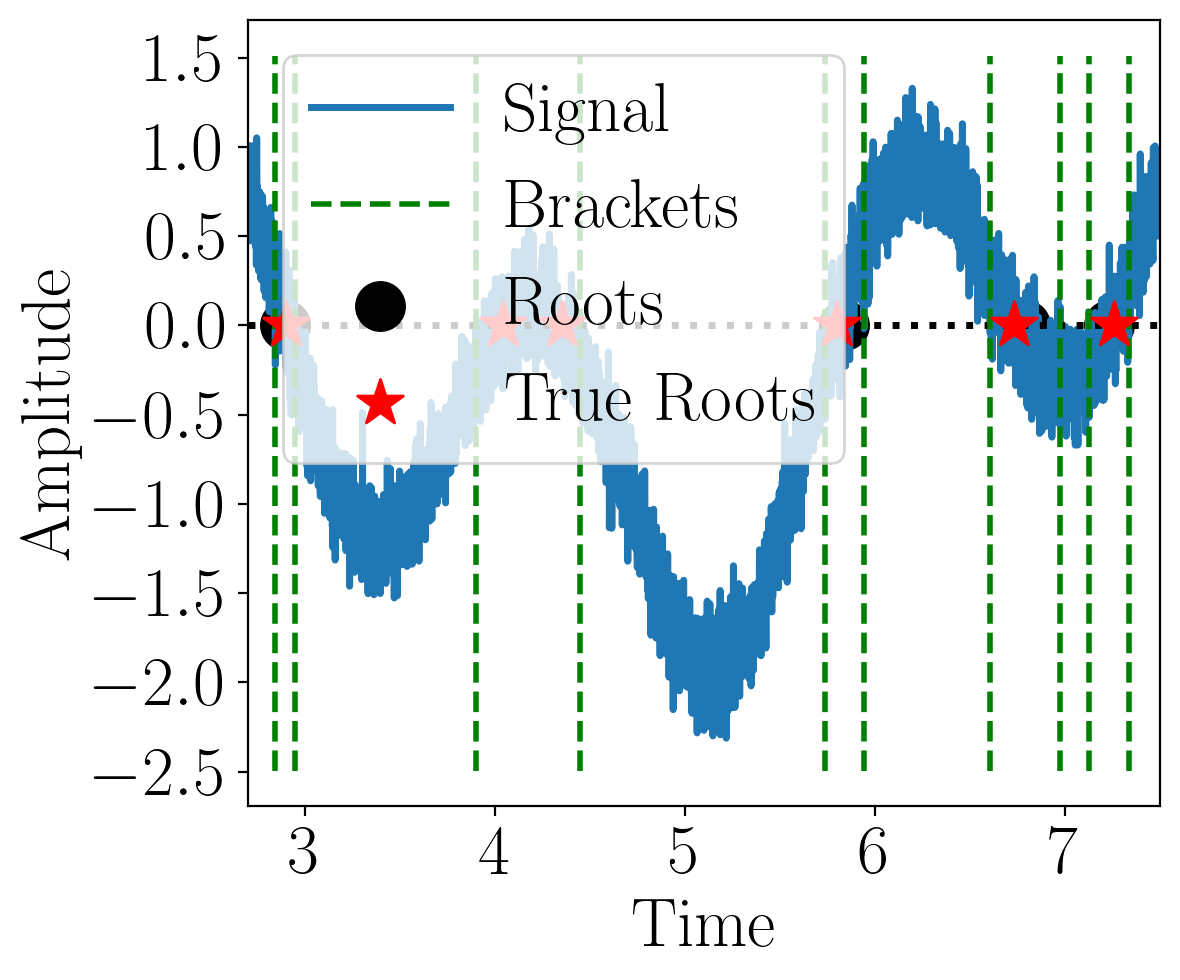

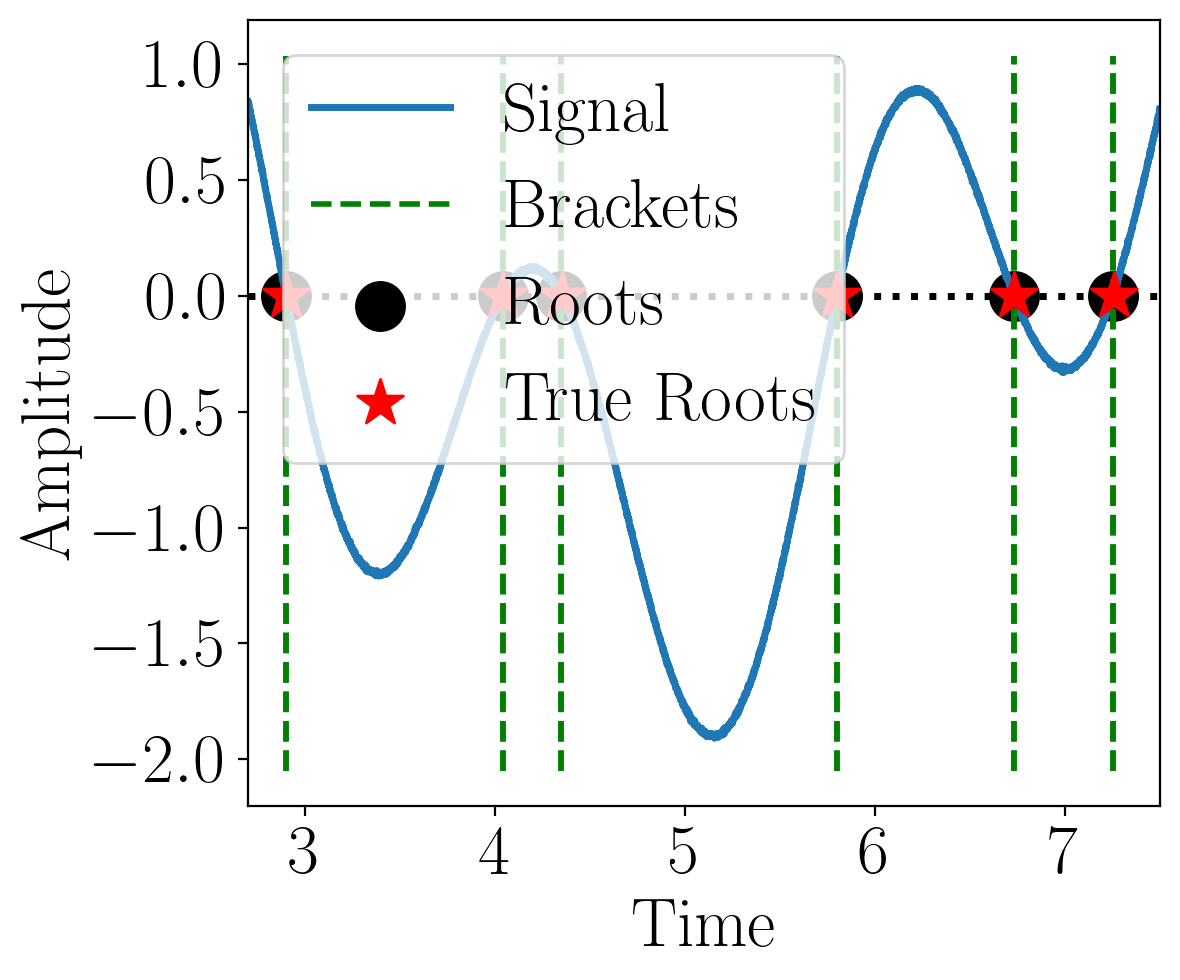

In [56]:
# x2

t1 = 2.7
tn = 7.5
fs = 1000
sample_num = np.multiply((tn - t1), fs)

for SNR_db in [15, 45]:

    t = np.linspace(t1, tn, round(sample_num), endpoint=True)
    sig1 = np.sin(t) + np.sin(10*t/3)

    power_signal = np.average(sig1 * sig1)
    SNR_100 = np.power(10, SNR_db / 10)
    mu_g, sigma = 0, np.sqrt(power_signal / SNR_100)
    noise = np.random.normal(mu_g, sigma, round(sample_num))
    sig1 = sig1 + noise

    brackets, ZC, flag = ZeDA(sig1, t1, tn, real=np.array([2.9, 4.039, 4.3499, 5.79986, 6.73198, 7.2598]), level=0.0,  plotting=True, method='std')

### Figure 9

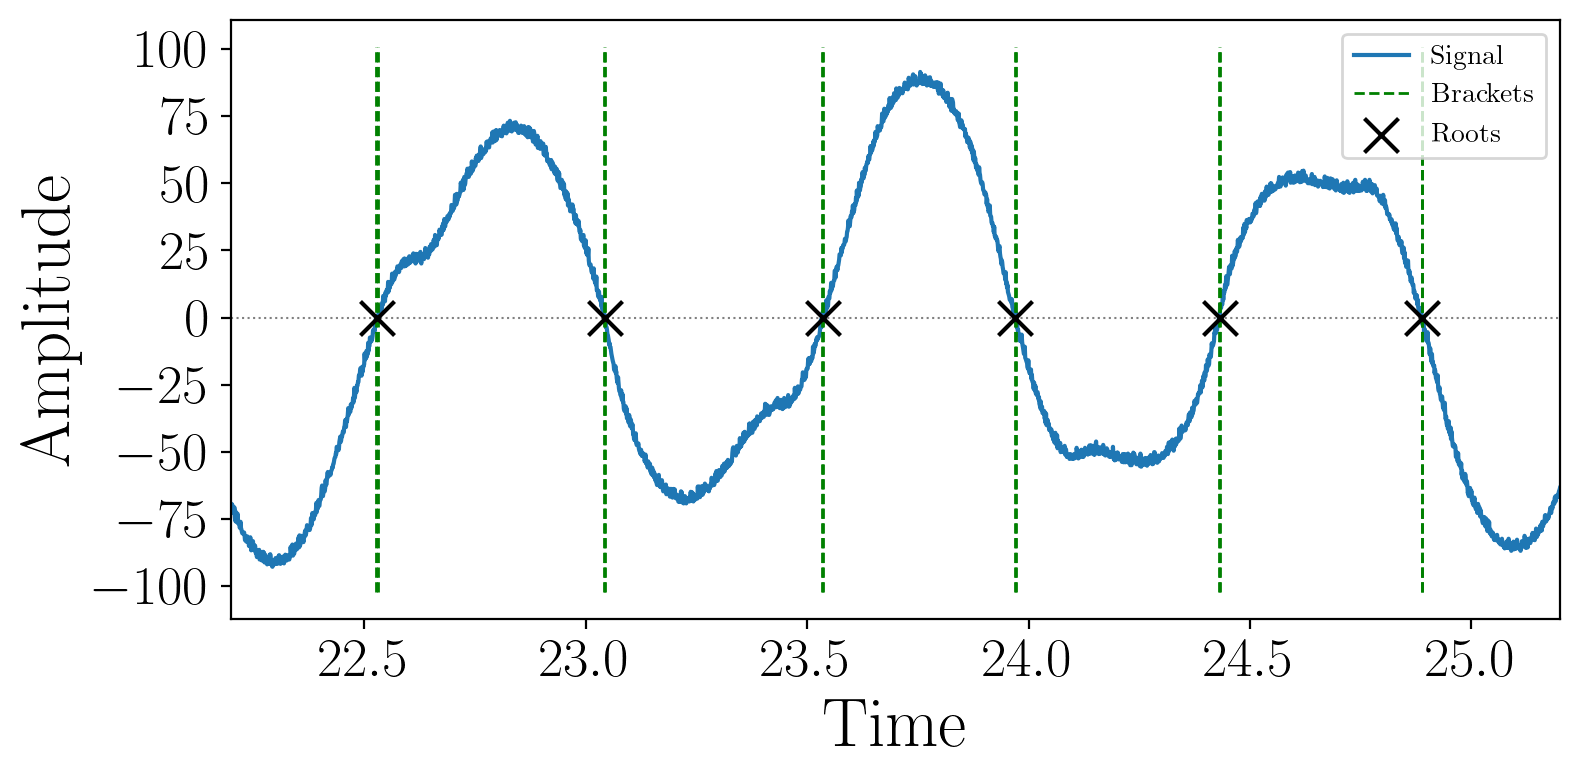

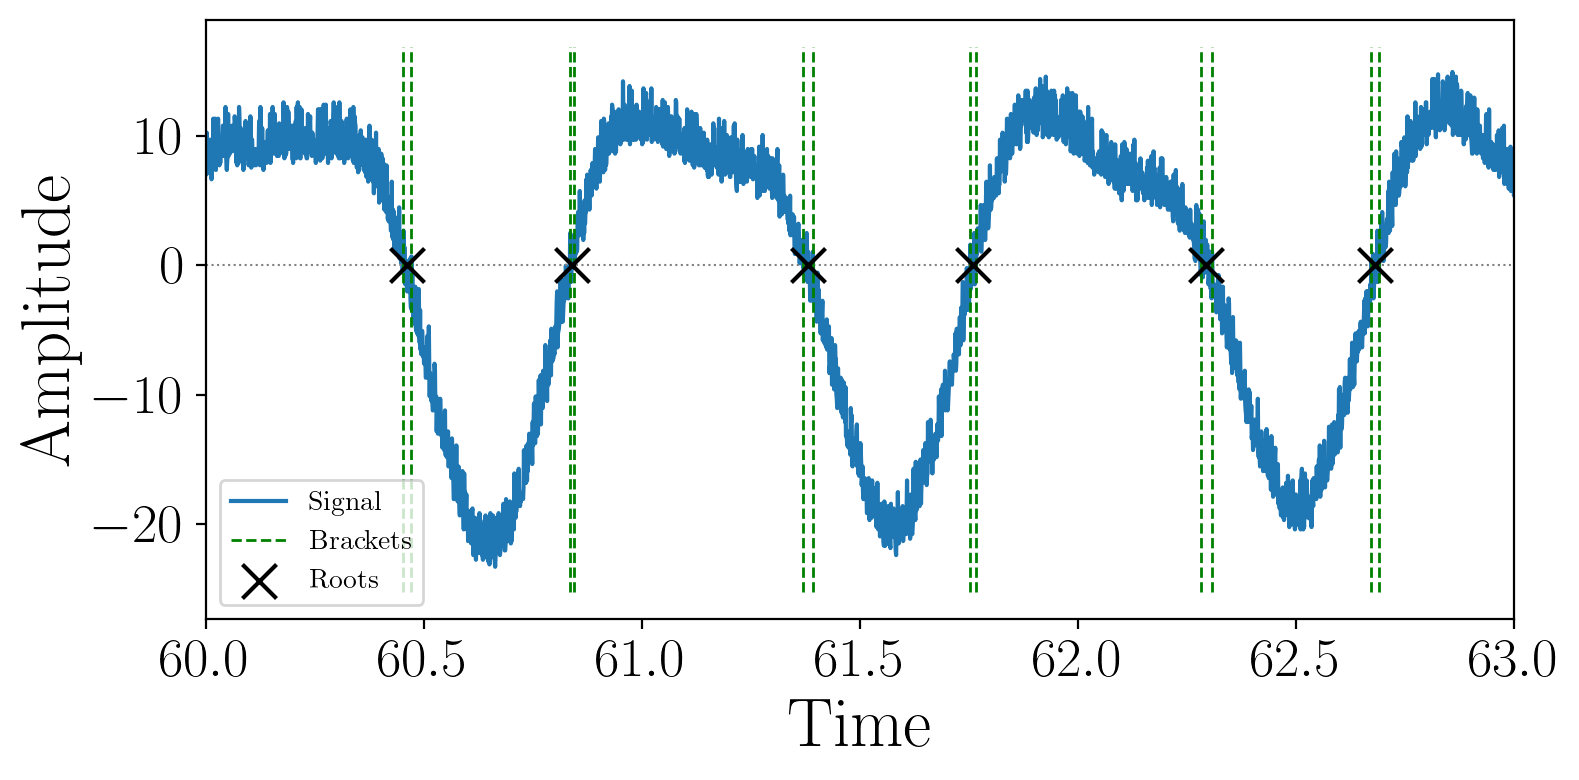

In [66]:
import scipy.io

mat = scipy.io.loadmat('C:\\Users\\sunia\\PycharmProjects\\LC_DP.mat')

time = mat['t']
theta = mat['theta']
time = time[:,0]
sig = theta[:,0]

for t1, tn in [(22.2, 25.2), (60.0, 63.0)]:

    t = time[np.where(time==t1)[0][0]:np.where(time==tn)[0][0]]
    sig1 = sig[np.where(time==t1)[0][0]:np.where(time==tn)[0][0]]

    brackets, ZC, flag = ZeDA(sig1, t1, tn, plotting=True, method='std')

In [75]:
import scipy.io

mat = scipy.io.loadmat('C:\\Users\\sunia\\PycharmProjects\\LC_DP.mat')

time = mat['t']
theta = mat['theta']
time = time[:,0]
sig = theta[:,0]

for t1, tn in [(22.2, 25.2), (60.0, 63.0)]:

    t = time[np.where(time==t1)[0][0]:np.where(time==tn)[0][0]]
    sig1 = sig[np.where(time==t1)[0][0]:np.where(time==tn)[0][0]]

    roots = []
    zeros = []
    for i in range(1, len(sig1)):

        prev = sig1[i-1]
        current = sig1[i]

        if np.sign(prev) != np.sign(current):
            bracket = [t[i-1], t[i]]
            roots.append(bracket)
            zeros.append((t[i-1]+t[i])/2.0)

    print(f'{len(zeros)} roots detected without filtering in [{t1}, {tn}].')

    # plt.figure(figsize=(8, 4), dpi=200)
    # plt.plot(t, sig1, linewidth=1.5, alpha=1)
    # plt.axhline(y=0, linewidth=0.75, linestyle=':', color='grey', label='_nolegend_')
    # plt.xlim([t1, tn])
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # plt.xlabel("Time", fontsize=25)
    # plt.ylabel("Amplitude", fontsize=25)
    #
    # ymin, ymax = plt.gca().get_ylim()
    # plt.vlines(roots, ymin=ymin, ymax=ymax, linewidth=1.0, color='green', linestyle='--')
    #
    # n = np.zeros(len(zeros))
    # plt.scatter(zeros, n, s=150, color='black', marker='x', zorder=2)
    # plt.legend(['Signal', 'Brackets', 'Roots'])
    #
    # plt.tight_layout()
    # plt.show()

18 roots detected without filtering in [22.2, 25.2].
56 roots detected without filtering in [60.0, 63.0].
